In [209]:
import datetime, time, math, os, json, shutil, asyncio, networkx as nx
from utils.gitutils import create_pull_request, clone_repo, create_branch, wipe_repo, prepare_repo
from utils.agent import Agent, GenerationConfig, Interaction, Team
from utils.stringutils import arr_from_sep_string, extract_markdown_blocks, markdown_to_dict, fuzzy_find, skwonk
from utils.filetreeutils import FileTree, write_file_tree
from utils.listutils import flatten
from utils.frameworkutils import DartAnalyzer
from dotenv import load_dotenv
from utils.graphutils import loose_level_order, collapsed_level_order
from utils.frameworkutils import Framework

In [210]:
repo_url = 'matplotlib/matplotlib'

In [211]:
# Clone the repo and make a new branch
repo = clone_repo(repo_url, max_size_mb=500)
local_repo_path = str(repo.working_dir)
working_dir_path = local_repo_path

In [212]:
import os
import ast
import networkx as nx
from utils.stringutils import deindent_code
import random

def build_dependency_graph(dir_path):
    """
    Build an import dependency graph of Python files in a directory, focusing on relative imports.
    
    Args:
        dir_path (str): Path to the directory containing Python files.
    
    Returns:
        networkx.DiGraph: Directed graph representing relative import dependencies.
    """
    graph = nx.DiGraph()
    for root, _, files in os.walk(dir_path):
        for file in files:
            if file.endswith(".py") or file.endswith(".pyi"):
                content = open(os.path.join(root, file), "r", encoding="utf-8").read()
                graph.add_node(file, content=deindent_code(content), size=len(content), complexity=random.uniform(0, 1))

    # Traverse all .py files in the directory
    for root, _, files in os.walk(dir_path):
        for file in files:
            if file.endswith(".py") or file.endswith(".pyi"):
                file_path = os.path.join(root, file)
                module_name = os.path.relpath(file_path, dir_path).replace(os.sep, ".")[:-3]
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    graph.add_node(module_name, content=deindent_code(content), size=len(content), complexity=random.uniform(0, 1))
                
                # Parse the file and extract relative imports
                with open(file_path, "r", encoding="utf-8") as f:
                    try:
                        tree = ast.parse(f.read(), filename=file_path)
                        for node in ast.walk(tree):
                            if isinstance(node, ast.ImportFrom):
                                # Handle only relative imports
                                if node.module and node.level > 0:
                                    # Construct the full module path for relative imports
                                    imported_module = resolve_relative_import(module_name, node.module, node.level)
                                    graph.add_node(imported_module, size=0)
                                    graph.add_edge(module_name, imported_module)
                                elif node.module and node.level == 0:
                                    name = node.module.split(".")[-1]
                                    if name == '__init__': # Skip __init__ imports
                                        continue
                                    # Check if name is an existing node
                                    for node in graph.nodes:
                                        if node.endswith(name):
                                            graph.add_edge(module_name, node)
                                            break
                    except SyntaxError:
                        print(f"Skipping {file_path}: Syntax error")
    to_remove = []
    for node in graph.nodes:
        # remove nodes with no content
        if graph.nodes[node]["size"] == 0:
            to_remove.append(node)
        # remove init files
        # elif node.endswith(".__init__"):
        #     to_remove.append(node)
    for node in to_remove:
        graph.remove_node(node)
    to_remove = []
    for node in graph.nodes:
        # remove nodes with no edges
        if len(graph.in_edges(node)) == 0 and len(graph.out_edges(node)) == 0:
            to_remove.append(node)
    for node in to_remove:
        graph.remove_node(node)
    return graph

def resolve_relative_import(current_module, imported_module, level):
    """
    Resolve a relative import to its absolute module path.
    
    Args:
        current_module (str): The current module's name.
        imported_module (str): The module being imported relatively.
        level (int): The number of parent directories to traverse.
    
    Returns:
        str: The resolved absolute module path.
    """
    current_parts = current_module.split(".")
    if level > len(current_parts):
        raise ValueError("Relative import level is too high")
    
    base_parts = current_parts[:-level]
    full_imported_module = ".".join(base_parts + [imported_module])
    return full_imported_module

In [213]:
from utils.filetreeutils import FileTree, write_file_tree

tree = FileTree.from_dir(local_repo_path)
nodes = [node for node in tree.nodes if node.endswith(".py") or node.endswith(".pyi")]
nodes

['tools/gh_api.py',
 'tools/boilerplate.py',
 'tools/cache_zenodo_svg.py',
 'tools/github_stats.py',
 'tools/embed_js.py',
 'tools/generate_matplotlibrc.py',
 'tools/triage_tests.py',
 'tools/run_examples.py',
 'tools/subset.py',
 'tools/visualize_tests.py',
 'tools/memleak.py',
 'tools/make_icons.py',
 'tools/check_typehints.py',
 'tools/stubtest.py',
 'ci/check_version_number.py',
 'ci/check_wheel_licenses.py',
 'ci/export_sdist_name.py',
 'ci/schemas/vendor_schemas.py',
 'lib/pylab.py',
 'lib/mpl_toolkits/axes_grid1/inset_locator.py',
 'lib/mpl_toolkits/axes_grid1/axes_grid.py',
 'lib/mpl_toolkits/axes_grid1/parasite_axes.py',
 'lib/mpl_toolkits/axes_grid1/anchored_artists.py',
 'lib/mpl_toolkits/axes_grid1/__init__.py',
 'lib/mpl_toolkits/axes_grid1/axes_size.py',
 'lib/mpl_toolkits/axes_grid1/mpl_axes.py',
 'lib/mpl_toolkits/axes_grid1/axes_rgb.py',
 'lib/mpl_toolkits/axes_grid1/axes_divider.py',
 'lib/mpl_toolkits/axes_grid1/tests/conftest.py',
 'lib/mpl_toolkits/axes_grid1/tests

In [214]:
dir_path = working_dir_path
dep_graph = build_dependency_graph(dir_path)

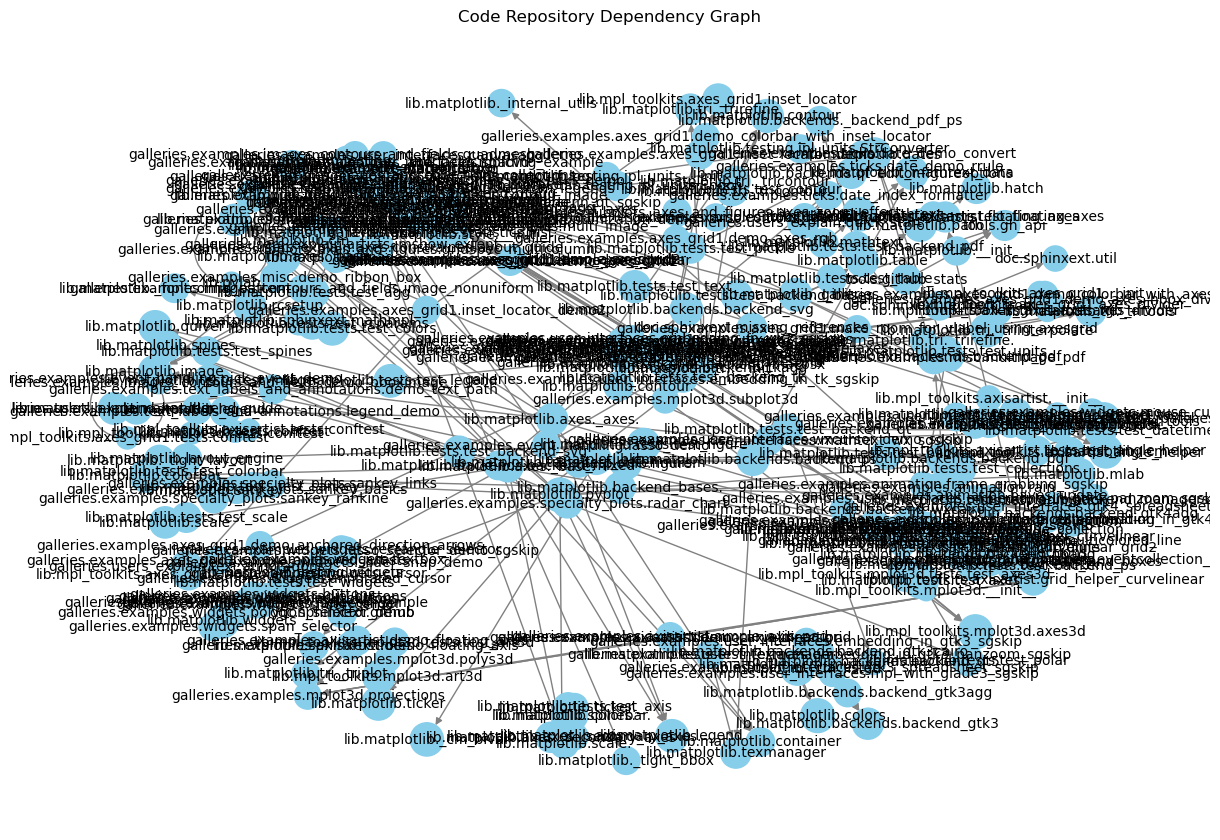

In [215]:
from matplotlib import pyplot as plt
def visualize_graph(G):
    # Extract node sizes based on the 'size' attribute
    node_sizes = [50*math.log(G.nodes[node]['size'] + 1) for node in G.nodes]
    
    # Generate positions for nodes using spring layout
    pos = nx.spring_layout(G)
    
    # Draw the graph
    plt.figure(figsize=(12, 8))
    labels = {node: f'{G.in_degree(node)}|{G.out_degree(node)}' for node in G.nodes}
    nx.draw(
        G,
        pos,
        with_labels=True,
        # labels=labels,  # Use in-degree as labels
        node_size=node_sizes,  # Scale by file size
        node_color="skyblue",
        edge_color="gray",
        arrows=True,
        font_size=10,
    )
    
    # Show plot
    plt.title("Code Repository Dependency Graph")
    plt.show()
visualize_graph(dep_graph)

In [216]:
# Sort dep_graph nodes by indegree and print
sorted_nodes = sorted(dep_graph.nodes(), key=lambda node: dep_graph.out_degree(node), reverse=True)
print("Nodes sorted by indegree:")
for node in sorted_nodes:
    print(f"{node}: {dep_graph.out_degree(node)}")

Nodes sorted by indegree:
lib.matplotlib.pyplot: 12
lib.matplotlib.axes._axes.: 10
lib.matplotlib.axes._base.: 10
lib.mpl_toolkits.axes_grid1.tests.test_axes_grid1: 5
lib.matplotlib.tri.__init__: 5
lib.matplotlib.tests.test_pickle: 4
lib.matplotlib.tests.test_backend_qt: 4
lib.matplotlib.cm: 3
lib.matplotlib.__init__: 3
lib.matplotlib.backends.backend_ps: 3
lib.matplotlib.tests.test_text: 3
lib.matplotlib.tests.test_units: 3
lib.matplotlib.testing.jpl_units.__init__: 3
galleries.examples.axes_grid1.inset_locator_demo2: 3
galleries.examples.event_handling.lasso_demo: 3
lib.mpl_toolkits.axisartist.__init__: 2
lib.matplotlib.figure.: 2
lib.matplotlib.backend_bases.: 2
lib.matplotlib.contour.: 2
lib.matplotlib.axes._base: 2
lib.matplotlib.backends.backend_tkagg: 2
lib.matplotlib.backends.backend_pdf: 2
lib.matplotlib.backends.backend_wxagg: 2
lib.matplotlib.backends.backend_pgf: 2
lib.matplotlib.backends.backend_mixed: 2
lib.matplotlib.backends.backend_macosx: 2
lib.matplotlib.backends.bac

In [217]:
import random
# u <- random node from dep_graph
u = random.choice(list(dep_graph.nodes()))
print(f"Random node: {u}")
print(f"Content: {dep_graph.nodes[u]['content']}")

Random node: galleries.examples.widgets.range_slider
Content: """
Image scaling using a RangeSlider
Using the RangeSlider widget to control the thresholding of an image.
The RangeSlider widget can be used similarly to the `.widgets.Slider`
widget. The major difference is that RangeSlider's ``val`` attribute
is a tuple of floats ``(lower val, upper val)`` rather than a single float.
See :doc:`/gallery/widgets/slider_demo` for an example of using
a ``Slider`` to control a single float.
See :doc:`/gallery/widgets/slider_snap_demo` for an example of having
the ``Slider`` snap to discrete values.
"""
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RangeSlider
# generate a fake image
np.random.seed(19680801)
N = 128
img = np.random.randn(N, N)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)
im = axs[0].imshow(img)
axs[1].hist(img.flatten(), bins='auto')
axs[1].set_title('Histogram of pixel intensities')
# Create the RangeSlide

In [218]:
max_words = max(dep_graph.nodes[u]['content'].count(' '), 1)
print(f"Max words: {max_words}")

max_lines = max(dep_graph.nodes[u]['content'].count('\n'), 1)
print(f"Max lines: {max_lines}")

Max words: 194
Max lines: 51


In [219]:
from utils.cache import LRUCache, CompositeCache
import numpy as np
from tqdm import tqdm

G = dep_graph
pdf = {node: np.log(G.nodes[node]['size']) for node in G.nodes}
for node in G.nodes:
    G.nodes[node]['complexity'] = random.uniform(0, 1)
lru = LRUCache(capacity=5)
lwc = CompositeCache(capacity=5)
caches = [lru, lwc]
rates = [[], []]
for _ in tqdm(range(1000)):
    for cache in caches:
        cache.clear()
        cache.initialize(G)
    for _ in range(80):
        u = random.choices(list(G.nodes()), weights=[pdf[node] for node in G.nodes()])[0]
        bug_complexity = random.uniform(0, 1)
        # Get dependencies of `u`
        dependencies = set(G[u]) | {u}
        # Randomly generated the number of queries to make based on the size of the file and the complexity
        num_queries = int(np.log(max(1, (G.nodes[u]['size'] * G.nodes[u]['complexity'] * bug_complexity)/16))/3 + 1)
        # Query cache based on dependencies
        for _ in range(num_queries):
            for dep in dependencies:
                for cache in caches:
                    cache.query(dep)
    for i, cache in enumerate(caches):
        rates[i].append(cache.hit_rate())
        cache.reset()

100%|██████████| 1000/1000 [00:04<00:00, 208.05it/s]


In [220]:
import numpy as np
from scipy.ndimage import median_filter

def moving_median(arr, window_size):
    """
    Smoothen an array by computing a moving median.
    
    Args:
        arr (list or np.ndarray): Input array to be smoothened.
        window_size (int): Size of the moving window.
        
    Returns:
        np.ndarray: Smoothened array.
    """
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd")
    
    return median_filter(arr, size=window_size)

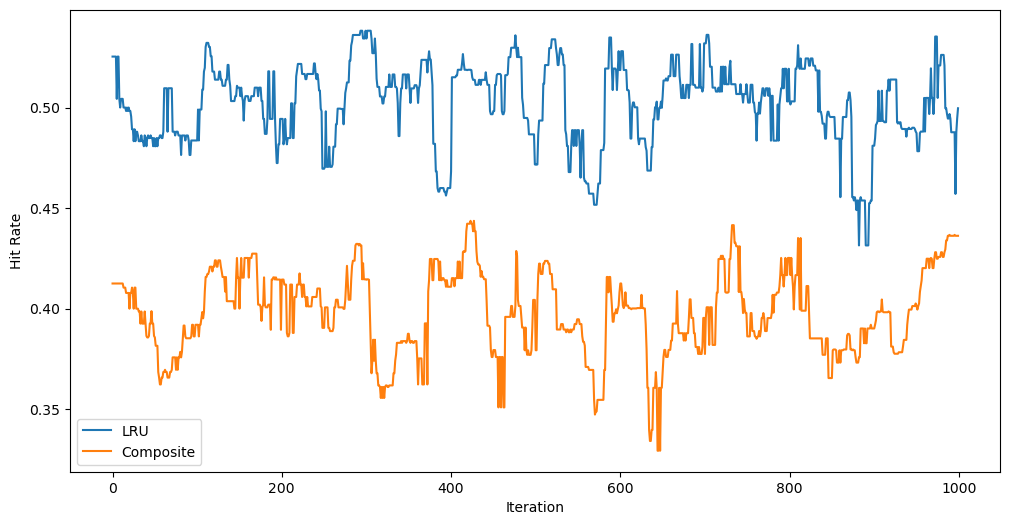

LRU Hit Rate: 0.49140507321972815
Composite Hit Rate: 0.3823799832790142


In [221]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(moving_median(rates[0], window_size=29), label="LRU")
plt.plot(moving_median(rates[1], window_size=29), label="Composite")
plt.xlabel("Iteration")
plt.ylabel("Hit Rate")
plt.legend()
plt.show()

print(f"LRU Hit Rate: {np.mean(rates[0])}")
print(f"Composite Hit Rate: {np.mean(rates[1])}")

## Analysis

In [222]:
repos = [
    'numpy/numpy',
    'scikit-learn/scikit-learn',
    'mwaskom/seaborn',
    'fastapi/fastapi',
    'fraimwork/fraimwork',
    'matplotlib/matplotlib',
]

In [223]:
graphs = {
    repo: build_dependency_graph(clone_repo(f'https://github.com/{repo}', max_size_mb=10**5).working_dir) for repo in repos
}

In [224]:
import networkx as nx
import numpy as np
import random

def generate_error_pdf(graph: nx.DiGraph, error_model='linear'):
    # Step 1: Extract file sizes from graph node attributes
    file_sizes = nx.get_node_attributes(graph, 'size')
    max_file_size = max(file_sizes.values())
    out_degrees = graph.out_degree()
    max_out_degree = max([out_degrees[node] for node in graph.nodes()])
    complexity = nx.get_node_attributes(graph, 'complexity')

    # Step 2: Apply the error model to file sizes
    if error_model == 'linear':
        error_weights = {node: 0.2*complexity[node] + 0.2*size/max_file_size + 0.6*out_degrees[node]/max_out_degree for node, size in file_sizes.items()}
    elif error_model == 'random':
        error_weights = {node: complexity[node] for node in file_sizes.keys()}
    else:
        raise ValueError("Unsupported error model")

    # Step 3: Normalize weights to create a probability distribution
    total_weight = sum(error_weights.values())
    pdf = {node: weight / total_weight for node, weight in error_weights.items()}

    return pdf

In [225]:
from utils.cache import Cache
import networkx as nx
import random
from tqdm import tqdm
from collections import defaultdict
from utils.graphutils import random_code_graph
import time

MIN_CACHE_SIZE = 5
MAX_CACHE_SIZE = 5

num_subclasses = len(Cache.__subclasses__())

sized_caches = {size: [CacheType(size) for CacheType in Cache.__subclasses__()] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
# caches[size][i] = cache of size `size` using the `i`th cache replacement policy

cache_hit_rate = {size: [defaultdict(int) for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
# cache_hit_rate[size][i][j] = avg hit rate for cache i, graph size j, cache size `size`

cache_timings = {size: [defaultdict(int) for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
# cache_timings[size][i][j] = avg time taken for cache i, graph size j, cache size `size`

for url, G in graphs.items():  # Loop over graphs
    local_hit_rates = {size: [[] for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
    # local_hit_rates[size][i] = hit rates for cache i of size `size`
    # local_timings = {size: [[] for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
    # local_timings[size][i] = timings for cache i of size `size`
    pdf = generate_error_pdf(G)
    for size, caches in sized_caches.items():
        for cache in caches:
            cache.clear()
            cache.initialize(G)
        for _ in range(100):  # Randomly select nodes to test
            u = random.choices(list(G.nodes()), weights=[pdf[node] for node in G.nodes()])[0]
            bug_complexity = random.uniform(0, 1)
            # Get dependencies of `u`
            dependencies = set(G[u]) | {u}
            # Randomly generated the number of queries to make based on the size of the file and the complexity
            num_queries = int(np.log(max(1, (G.nodes[u]['size'] * G.nodes[u]['complexity'] * bug_complexity)/2)) + 1)
            # Query cache based on dependencies
            for _ in range(num_queries):
                for dep in dependencies:
                    for size, caches in sized_caches.items():
                        for i, cache in enumerate(caches):
                            # print(cache.__class__, size)
                            # print(cache.graph.nodes[dep])
                            cache.query(dep)
        for size, caches in sized_caches.items():
            for i, cache in enumerate(caches):
                local_hit_rates[size][i].append(cache.hit_rate())
                cache.reset()
    for size, caches in sized_caches.items():
        for i in range(num_subclasses):
            cache_hit_rate[size][i][url] = np.mean(local_hit_rates[size][i])
            # cache_timings[size][i][url] = np.mean(local_timings[size][i])

## Plotting

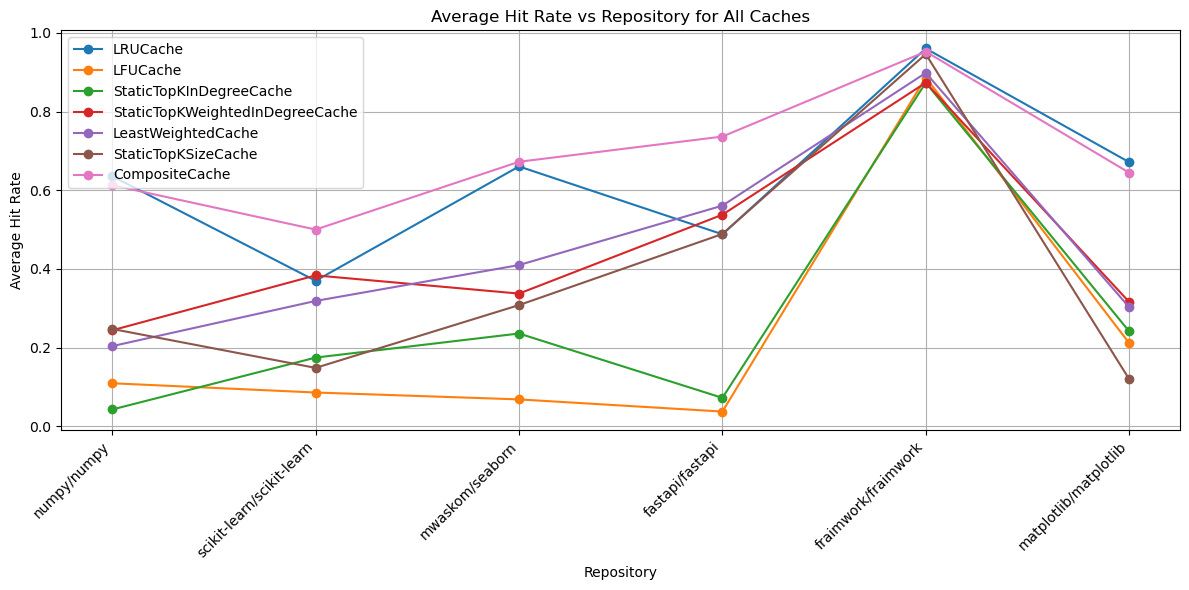

In [226]:
import numpy as np
import matplotlib.pyplot as plt

# Convert cache_hit_rate to a numpy matrix
# Dimensions: (num_subclasses, num_repositories)
repositories = list(graphs.keys())  # Assuming `graphs` is a dictionary with repositories as keys
num_repositories = len(repositories)

# Initialize an empty matrix for average hit rates
average_hit_rates = np.zeros((num_subclasses, num_repositories))

# Populate the matrix with average hit rates over all sizes for each cache and repository
for i in range(num_subclasses):  # Loop over cache types
    for j, repo in enumerate(repositories):  # Loop over repositories
        total_hit_rate = 0
        count = 0
        for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE + 1):  # Loop over sizes
            if repo in cache_hit_rate[size][i]:
                total_hit_rate += cache_hit_rate[size][i][repo]
                count += 1
        average_hit_rates[i, j] = total_hit_rate / count if count > 0 else 0

# Plotting the results
plt.figure(figsize=(12, 6))

for i, cache in enumerate(Cache.__subclasses__()):
    plt.plot(repositories, average_hit_rates[i], label=f'{cache.__name__}', marker='o')

plt.xlabel('Repository')
plt.ylabel('Average Hit Rate')
plt.title('Average Hit Rate vs Repository for All Caches')
plt.xticks(rotation=45, ha='right')  # Rotate repository names for better readability
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()